# IMDB Movie Review Sentiment Analysis

## Installation

In [1]:
# !pip install pandas
# !pip install scikit-learn scipy matplotlib
# !pip install spacy-langdetect
# !pip install deep_translator
# !pip install bs4
# !pip install emoji
# !pip install textblob
# !pip install vaderSentiment
# !pip install imblearn
# !pip install accelerate -U
# !pip install sentencepiece
# !pip install --upgrade transformers
# !pip install contractions
# !pip install pyspellchecker
# !pip install wordsegment
# !pip install spacy
# !pip install spacy-transformers
# !python -m spacy download en_core_web_trf

In [2]:
# # GPU setup for spacy to use
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !pip install -U spacy[cuda11x]
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
# print(torch.cuda.get_device_name(0))

## Setup

In [3]:
# Import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Libraries for text preprocessing
import re
import string
import nltk
import contractions
import spacy
import emoji
from nltk.corpus import stopwords
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from spellchecker import SpellChecker
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize

# Libraries for model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

# Suppress warnings
from transformers import logging
import warnings
warnings.simplefilter("ignore", UserWarning)
logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

from spacy.language import Language
from spacy_langdetect import LanguageDetector
from deep_translator import GoogleTranslator

spacy.prefer_gpu()
# spacy.require_gpu() # Use GPU rather than CPU, can commented it if you want to use CPU

# Function to create a language detector component
def create_language_detector(nlp, name):
    return LanguageDetector()

# Register the language detector factory if it's not already registered
if not Language.has_factory("language_detector"):
    Language.factory("language_detector", func=create_language_detector)
    
# Load the English model from spaCy
nlp = spacy.load('en_core_web_trf', disable=['tok2vec', 'morphologizer','ner'])

# Add the language detector to the pipeline if not already present
if 'language_detector' not in nlp.pipe_names:
    nlp.add_pipe('language_detector', last=True)

In [4]:
# Load data
imdb_df = pd.read_csv(r'data\raw_datasets\dataset9.csv', usecols=['review'])
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12848 entries, 0 to 12847
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  12848 non-null  object
dtypes: object(1)
memory usage: 100.5+ KB


# Text Processing

### Lowercasing Text

In [5]:
# Lower case
print('CHEN HUI IS a Genius'.lower())

chen hui is a genius


### Remove HTML Tags

In [6]:
# Function to remove HTML Tags
def remove_html_tags(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    return text

# Demo
print(remove_html_tags('<html><body><p>chen hui is a genius</p></body></html>'))

chen hui is a genius


### Remove URLs

In [7]:
# Function to remove URL
def remove_url(text):
    # Regex pattern for url
    pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Replace url with empty string
    return pattern.sub(r'', text)

# Demo
print(remove_url('MMU Url is https://mmu.edu.my'))

MMU Url is 


### Remove Punctations

In [8]:
# Punctuations is referring to some special characters like !, ? etc
def remove_punc(text):
    # Remove punctuation and add a space after removing punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Trim any leading or trailing whitespace
    text = text.strip()
    
    return text

# Demo
print(remove_punc('hello! how are you???i am fine.thank you. gg! (ABC) !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))

hello how are you i am fine thank you gg ABC


### Handling Chat Words

In [9]:
# Reference: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
# Considering there might have slang words used movie reviews
chat_words = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
    "1st": "first",
    "2nd": "second",
    "3RD": "third",
    "4th": "fourth",
    "5th": "fifth",
    "6th": "sixth",
    "7th": "seventh",
    "8th": "eighth",
    "9th": "ninth",
    "10th": "tenth",
    "11th": "eleventh",
    "12th": "twelfth",
    "13th": "thirteenth",
    "14th": "fourteenth",
    "15th": "fifteenth",
    "16th": "Sixteenth",
    "17th": "seventeenth",
    "18th": "eighteenth",
    "19th": "nineteenth",
    "20th": "twentieth",
    "vs": "versus",
    "hah": "laughter",
    "haha": "laughter",
    "hahaha": "laughter",
    "haa": "laughter",
    "ha": "laughter",
}


# Function
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.lower() in chat_words:
            new_text.append(chat_words[i.lower()])
        else:
            new_text.append(i)
    return " ".join(new_text)

# Demo
print(chat_conversion("chenhui is a nature born g9").lower())

chenhui is a nature born genius


### Spelling Correction

In [18]:
# # Import textblob to handle spelling issue
# print(TextBlob('chenHui is a nature born Genias').correct().string)

# Initialize the spell checker
spell = SpellChecker()

# List of known proper nouns or terms to exclude from correction
known_proper_nouns = {'godzilla', 'imdb'}
def correct_spelling(text):
    # Process the text with spaCy
    doc = nlp(text)
    corrected_tokens = []
    
    for token in doc:
        # print(token.text, ' - ',token.pos_)
        
        # Add the token if it's not a proper noun
        if token.pos_ in {'PROPN'} or token.text in known_proper_nouns:
            corrected_tokens.append(token.text)
        else:
            # Correct the token if it's misspelled
            # Check if the token is a noun
            
            corrected_word = spell.correction(token.text)
            corrected_tokens.append(corrected_word if corrected_word else token.text)
    
    # Combine the corrected tokens into a single text string
    corrected_text = ' '.join(corrected_tokens)
    return corrected_text

# Example usage
text = "ChenHui is a natura bxrn genias"
corrected_text = correct_spelling(text)
print(corrected_text)

ChenHui is a natural born genius


### Handling Stop Words

In [47]:
# Stopwords refers to words that are not meaningful to the sentence
stopword = stopwords.words('english')

# Function to remove stopwords such as a, an, the, at, etc
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

# Demo
print(remove_stopwords('''ChenHui is and a nature-born genius. His exceptional intellect and curiosity allow him to grasp complex concepts effortlessly. 
                       Whether in science, mathematics, or art, ChenHui's brilliance shines through, making him a remarkable figure in any field he explores.'''))

ChenHui nature-born genius. His exceptional intellect curiosity allow grasp complex concepts effortlessly. Whether science, mathematics, art, ChenHui's brilliance shines through, making remarkable figure field explores.


### Handling Emojis

In [48]:
# Demo
print(emoji.demojize("huh 🤨"))
print(remove_punc('huh :face_with_raised_eyebrow:'))

huh :face_with_raised_eyebrow:
huh face with raised eyebrow


### Expand Contraction

In [49]:
def expand_contractions(text):
    return contractions.fix(text)

# Demo
print(expand_contractions('''we've, I'm, you're, and you'll'''))

we have, I am, you are, and you will


### Split Concatenated Words

In [50]:
from wordsegment import load, segment
load()

def split_concatenated_words(text):
    # Convert input list of words to a single string
    if isinstance(text, list):
        text = ' '.join(text)
        
    split_words = segment(text)

    return ' '.join(split_words) # Join the split words back into a single string and return

text = 'garbageAnother exampleText to test the splitconcatenatedwords function'
split_text = split_concatenated_words(text)
print('Splitted text:',split_text)

Splitted text: garbage another example text to test the split concatenated words function


### Normalize Elongated Words

In [51]:
# Function to normalize elongated words (e.g., "sooooo" -> "so")
def normalize_elongated_words(text):
    # Replace elongated words with their standard forms
    regex = r'(\w)\1{2,}'
    return re.sub(regex, r'\1\1', text)

# Example text with elongated words
text = "This is sooooooo amaaaazing! wowwwww! happpyyyy toooooo hellll howwwww"
text = remove_punc(text)
text = normalize_elongated_words(text)
print(text)
text = correct_spelling(text)
print(text)

This is soo amaazing woww happyy too hell howw
This is so amazing wow happy too hell how


### Tokenization

In [52]:
# Function to tokenize the text using spaCy
def tokenize_text(text):
    #Replace non-ASCII characters with spaces
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.strip()
    return [tok.text for tok in nlp.tokenizer(text)]

# Example usage
text = '''你好 I'm not going to Spoil the movie here because is something that you need to see in the Big Screen, whit your family and friends but man this movie has a lot Monster fight and action that you will not be disappointed, Godzilla and Kong are totally badass in this movie, in this one I love that Jia return she is the best human character in this movie just like in the Godzilla vs Kong. The movie kept me entertained all the time through the whole movie, and the visuals and design are amazing in this movie, and something I'm going to say there are a lot lore in the Hollow Earth that has to be explored
10/10 Amazing 猸.? out of 62 found this helpful.'''

# Tokenize the cleaned text
tokens = tokenize_text(text)

# Print the tokens
print(tokens)

['I', "'m", 'not', 'going', 'to', 'Spoil', 'the', 'movie', 'here', 'because', 'is', 'something', 'that', 'you', 'need', 'to', 'see', 'in', 'the', 'Big', 'Screen', ',', 'whit', 'your', 'family', 'and', 'friends', 'but', 'man', 'this', 'movie', 'has', 'a', 'lot', 'Monster', 'fight', 'and', 'action', 'that', 'you', 'will', 'not', 'be', 'disappointed', ',', 'Godzilla', 'and', 'Kong', 'are', 'totally', 'badass', 'in', 'this', 'movie', ',', 'in', 'this', 'one', 'I', 'love', 'that', 'Jia', 'return', 'she', 'is', 'the', 'best', 'human', 'character', 'in', 'this', 'movie', 'just', 'like', 'in', 'the', 'Godzilla', 'vs', 'Kong', '.', 'The', 'movie', 'kept', 'me', 'entertained', 'all', 'the', 'time', 'through', 'the', 'whole', 'movie', ',', 'and', 'the', 'visuals', 'and', 'design', 'are', 'amazing', 'in', 'this', 'movie', ',', 'and', 'something', 'I', "'m", 'going', 'to', 'say', 'there', 'are', 'a', 'lot', 'lore', 'in', 'the', 'Hollow', 'Earth', 'that', 'has', 'to', 'be', 'explored', '\n', '10/10'

### Lemmatization

In [53]:
# wordnet_lemmatizer = WordNetLemmatizer()
# # Demo
# token_text = [wordnet_lemmatizer.lemmatize(word, pos = wordnet.VERB) for word in token_text]
# print(token_text)

def lemmatize_text(text):
    # Check if 'text' is a list
    if isinstance(text, list):
        text = ' '.join(text)
        
    # Lemmatize the text 
    doc = nlp(text)
    # for token in doc:
    #     print(token.text, token.pos_, token.lemma_)
    return [token.lemma_ for token in doc]

# Example usage
text1 = "I'm not going to spoil the movie here because it is something that you need to see in the big screen, with your family and friends, but man this movie has a lot monster fight and action that you will not be disappointed. Godzilla and Kong are totally badass in this movie. In this one I love that Jia returns; she is the best human character in this movie just like in the Godzilla vs Kong. The movie kept me entertained all the time through the whole movie, and the visuals and design are amazing in this movie. And something I'm going to say, there is a lot lore in the Hollow Earth that has to be explored. 10/10 Amazing. ? out of 62 found this helpful."
text2= 'hard core kaiju fan many year love treat gorilla move late opinion first two series gorilla gorilla king monster somewhat reality base obviously make child criticism g v k end particular movie much far fetched fantasy base much cartoon bottom line make monster much human intelligence actually animalistic like watch superhero movie opinion make monster superhero huge mistake happen result gorilla move become silly low budget kiss move since ridicule decade varnish gorilla image understand writer try creative give fan something different monster move do without cheese please stop make monster human enjoy movie admit somewhat disappointed'

lemmas_text1 = lemmatize_text(text1)
lemmas_text2 = lemmatize_text(text2)
print(lemmas_text1)
print(lemmas_text2)

['I', 'be', 'not', 'go', 'to', 'spoil', 'the', 'movie', 'here', 'because', 'it', 'be', 'something', 'that', 'you', 'need', 'to', 'see', 'in', 'the', 'big', 'screen', ',', 'with', 'your', 'family', 'and', 'friend', ',', 'but', 'man', 'this', 'movie', 'have', 'a', 'lot', 'monster', 'fight', 'and', 'action', 'that', 'you', 'will', 'not', 'be', 'disappoint', '.', 'Godzilla', 'and', 'Kong', 'be', 'totally', 'badass', 'in', 'this', 'movie', '.', 'in', 'this', 'one', 'I', 'love', 'that', 'Jia', 'return', ';', 'she', 'be', 'the', 'good', 'human', 'character', 'in', 'this', 'movie', 'just', 'like', 'in', 'the', 'Godzilla', 'vs', 'Kong', '.', 'the', 'movie', 'keep', 'I', 'entertain', 'all', 'the', 'time', 'through', 'the', 'whole', 'movie', ',', 'and', 'the', 'visual', 'and', 'design', 'be', 'amazing', 'in', 'this', 'movie', '.', 'and', 'something', 'I', 'be', 'go', 'to', 'say', ',', 'there', 'be', 'a', 'lot', 'lore', 'in', 'the', 'Hollow', 'Earth', 'that', 'have', 'to', 'be', 'explore', '.', '1

### Text Translation

In [54]:
# Function to detect the language of a token using spaCy
def detect_language(text):
    doc = nlp(text)
    return doc._.language

# Function to translate text to English if it's not in English
def translate_text(text):
    language = detect_language(text)['language']
    # print(f"{text} - {language}")
    if language != 'en':
        translated_text =  GoogleTranslator(source='auto', target='english').translate(text)
        # print(f"Translated text: {translated_text}")
        return translated_text
    return text

print(translate_text('天才'))

genius


### Remove Non-English Text

In [55]:
# Create a set of English words in SpaCy's vocabulary
# words = set(nlp.vocab.strings)
# words = set(nltk.corpus.words.words())

# English vocabulary list used for removing non-english text refering to https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt
with open('words_alpha.txt') as f:
    words_alpha = set(word.strip().lower() for word in f)

def remove_non_english_text(text):
    doc = nlp(text)
    cleaned_tokens = []
    
    for token in doc:
        # Keep tokens that are in the words list, are named entities, or are non-alphabetic
        if token.lower_ in words_alpha or token.ent_type_ or not token.is_alpha:
            cleaned_tokens.append(token.text)
    
    return " ".join(cleaned_tokens)

print(remove_non_english_text("gggggggggggggggggg io andiamo to the beach with my amico and Godzilla."))
print(remove_non_english_text("fhdhfhfhfhfhfhfhfjfj to the park for a picnic with Sarah and John."))

io to the beach with my and .
to the park for a picnic with Sarah and John .


## Start Preprocess

In [39]:
from tqdm import tqdm

def preprocess_text(text):
    #Translate text to English if it's not in English
    text = translate_text(text) if text is not None else None
    # print(f'Translated text: {text}')
    # Converting to lowercase
    text = text.lower() if text is not None else None
    
    # Removing HTML Tags
    text = remove_html_tags(text) if text is not None else None
    
    # Remove URLs
    text = remove_url(text) if text is not None else None
    
    # Handling emojis
    text = emoji.demojize(text) if text is not None else None
    
    # Handling chat words
    text = chat_conversion(text).lower() if text is not None else None
    
    # Removing numbers
    text = re.sub(r'\d+', '', text) if text is not None else None
    
    # Expand contractions
    text = expand_contractions(text) if text is not None else None
    
    text = normalize_elongated_words(text) if text is not None else None
    
    # Removing punctuations
    text = remove_punc(text) if text is not None else None
    
    # Split concatenated words
    text = split_concatenated_words(text) if text is not None else None
    
    # Spelling correction
    # text = TextBlob(text).correct().string
    text = correct_spelling(text) if text is not None else None
    
    # Removing stopwords
    text = remove_stopwords(text) if text is not None else None
    
    # Tokenization
    tokens = tokenize_text(text) if text is not None else None
    
    # Lemmatization
    tokens = lemmatize_text(tokens) if tokens is not None else None

    # Remove non-English words
    text = remove_non_english_text(' '.join(tokens)) if tokens is not None else None

    if text is None and tokens is None:
        return None
    # return ' '.join(tokens)
    return text

# # tqdm.pandas(desc="Processing")  # Initialize tqdm with pandas
# print('Preprocessing...')
# tqdm.pandas()

# # Testing
# # df = pd.DataFrame({'review': ['''AQUAMAN MOVIE NON SPOILER REVIEWWhy you should not worry that DC messed up again?Its Directed by James Wan, if you liked The Fast & Furious 7 n cried, yea its him who directed and has directed this one as well so you know its in good hands.Why should you see it?Its easily the most Beautiful Super Hero Movie ever馃槏 and is in same conversation with Avatar(2009 blue fantasy).Trust me on this one, it is very very extremely Beautiful(sorry Black Panther but wakanda is no match for the sea). The Underwater scenes are those non ever seen on screen and a cinematic experience is a must for this one 馃槏.Plot & StoryThe begging is a slow start and somehow hints that this would be another disappointing DC film as scenes are rushed. For me Narration is just a lazy style of story telling(not a fan) and it does turn me off, but they added present day narration and flash Backs which make it kind of Unique and i would give it a pass for that. The other thing is that the story is plan simple and straight to the Origin story of Establishing the Plot.Action & HumorAction packed film with good fight scenes and well directed Camera Shoots 馃槺馃槺 There is one you already saw in the Trailer and it Is well done. After Watching this Film Aquaman ranks Just after Superman and Wonder Woman(sorry Batman but its true) Watching this film makes me Hate Justice League even more as Aquaman is very Powerful and should have been utilized in that film. In terms of Humor 11 out of 20 jokes are funny is all i will say.Where does it stand among DCEU films?Maybe some will disagree, but There is Batman The Dark Night and then AQUAMAN. Yes i said it, it second best.Conclusion.You dont need to be a comic book or Super Hero fan to enjoy this movie. Dear Parents you and your Children will never forget watching such a film, take them and yourself this coming weekend at Fresh View Cinemas I WILL REPEAT, ITS THE MOST BEAUTIFUL SUPER HERO FILM EVER.''']})
# # df['review'] = df['review'].progress_apply(preprocess_text)
# # print('1. ',df['review'][0])
# # print('2. ',df['review'][1])
# imdb_df['review'] = imdb_df['review'].progress_apply(preprocess_text)
# print('Preprocessing done.')


In [43]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Labelling the sentiment
def analyze_sentiment_row(row):
    analyzer = SentimentIntensityAnalyzer()
    text = row['review']  # column used for polarity and subjectivity calculations
    
    # Create a TextBlob object
    blob = TextBlob(text)
    
    # Get the polarity and subjectivity
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    # Get the VADER sentiment scores
    score = analyzer.polarity_scores(text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    
    # Determine the sentiment category
    if neg > pos:
        sentiment = "negative"
    elif pos > neg:
        sentiment = "positive"
    else:
        sentiment = "neutral"
    
    # Assign the values back to the row
    row['polarity'] = polarity
    row['subjectivity'] = subjectivity
    row['sentiment'] = sentiment
    
    return row

# print(imdb_df[imdb_df.isnull().any(axis=1)])
# imdb_df.dropna(inplace=True)
# print('Labelling...')
# imdb_df = imdb_df.progress_apply(analyze_sentiment_row, axis=1)
# print('Done...')

# # Save to CSV
# imdb_df.to_csv('data\processed\imdb_cleaned_9.csv', index=False) # Careful with this

# Modeling

In [7]:
# Define the list of CSV file paths
file_paths = [
    'data/processed/imdb_cleaned_1.csv',
    'data/processed/imdb_cleaned_2.csv',
    'data/processed/imdb_cleaned_3.csv',
    'data/processed/imdb_cleaned_4_5_6.csv',
    'data/processed/imdb_cleaned_7.csv',
    'data/processed/imdb_cleaned_8.csv',
    'data/processed/imdb_cleaned_9.csv',
]
# Load all CSV files into a single DataFrame
dataframes = [pd.read_csv(file, usecols=['review', 'sentiment']) for file in file_paths]

# Concatenate all dataframes
imdb_df = pd.concat(dataframes, ignore_index=True)

# Drop any rows with missing values
imdb_df.dropna(inplace=True)

# Display DataFrame information
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124321 entries, 0 to 124327
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     124321 non-null  object
 1   sentiment  124321 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB


In [8]:
imdb_df.sentiment.value_counts()

sentiment
positive    99737
negative    23576
neutral      1008
Name: count, dtype: int64

### EDA

In [276]:
from plotly import graph_objs as go
from collections import Counter
from plotly.subplots import make_subplots

def plot_class_distribution(df, label_column, title="Class Distribution"):
    """
    Plots the class distribution as a pie chart and a histogram with percentages using Plotly and custom colors.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    label_column (str): The name of the column containing the class labels.
    title (str): The title of the plot.
    """
    # Get class distribution and counts
    class_counts = df[label_column].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    
    # Calculate percentages
    class_counts['Percentage'] = (class_counts['Count'] / class_counts['Count'].sum() * 100).round(2)

    # Define custom colors
    color_map = {'positive': '#23C864',
                 'neutral': '#41C5FF',
                 'negative': '#FF4141'}

    # Create subplots: 1 row, 2 columns
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'pie'}, {'type': 'bar'}]])

    # Pie chart
    fig.add_trace(
        go.Pie(labels=class_counts['Class'], values=class_counts['Count'], name="Class Distribution",
               marker=dict(colors=[color_map[cls] for cls in class_counts['Class']])),
        row=1, col=1
    )

    # Set text position to 'outside' only for 'neutral' class, 'inside' otherwise
    fig.update_traces(textposition=['outside' if cls == 'neutral' else 'inside' for cls in class_counts['Class']],
                      textinfo='percent+label', row=1, col=1)

    # Histogram
    fig.add_trace(
        go.Bar(x=class_counts['Class'], y=class_counts['Count'],
               marker_color=[color_map[cls] for cls in class_counts['Class']],
               text=class_counts['Count'], textposition='outside', showlegend=False),
        row=1, col=2
    )

    # Update layout for better appearance
    fig.update_layout(
        title=dict(text=title, x=0.5, y=0.95),
        showlegend=True,
        height=500,
        width=1000,
        yaxis=dict(title='Count')
    )

    # Show plot
    fig.show()

plot_class_distribution(imdb_df, 'sentiment', title="IMDb Sentiment Class Distribution")

In [277]:
from nltk.util import ngrams

# Function to tokenize the text using spaCy
def tokenize_text(text):
    # Replace non-ASCII characters with spaces
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.strip()
    return [tok.text for tok in nlp.tokenizer(text)]

# Function to get n-grams from tokens
def get_ngrams(tokens, n):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

def plot_top_words_per_class(df, text_column, label_column, top_n=20):
    """
    Plots the top N most common unigrams, bigrams, and trigrams for each sentiment class using Plotly.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the text data and labels.
    text_column (str): The name of the column containing the text data.
    label_column (str): The name of the column containing the sentiment labels.
    top_n (int): Number of top words to plot per class (default is 20).
    """
    # Define custom colors
    color_map = {'positive': '#23C864',
                 'neutral': '#41C5FF',
                 'negative': '#FF4141'
                 }
    
    # Initialize counters for each sentiment class and n-gram type
    counters = {
        'unigram': {'positive': Counter(), 'neutral': Counter(), 'negative': Counter()},
        'bigram': {'positive': Counter(), 'neutral': Counter(), 'negative': Counter()},
        'trigram': {'positive': Counter(), 'neutral': Counter(), 'negative': Counter()}
    }
    
    # Process each row in the DataFrame
    for index, row in df.iterrows():
        text = row[text_column]
        tokens = tokenize_text(text)  # Tokenize using spaCy
        
        # Update counters based on sentiment label
        sentiment = row[label_column]
        counters['unigram'][sentiment].update(tokens)
        counters['bigram'][sentiment].update(get_ngrams(tokens, 2))
        counters['trigram'][sentiment].update(get_ngrams(tokens, 3))
    
    # Prepare data for plotting
    plot_data = {'positive': [], 'neutral': [], 'negative': []}
    for ngram_type in ['unigram', 'bigram', 'trigram']:
        for sentiment in ['positive', 'neutral', 'negative']:
            top_ngrams = dict(counters[ngram_type][sentiment].most_common(top_n))
            sorted_ngrams = {k: v for k, v in sorted(top_ngrams.items(), key=lambda item: item[1])}
            plot_data[sentiment].append((list(sorted_ngrams.keys()), list(sorted_ngrams.values())))

    # Create subplots: 3 rows, 3 columns
    fig = make_subplots(rows=3, cols=3, subplot_titles=(
        'Positive Unigrams', 'Neutral Unigrams', 'Negative Unigrams',
        'Positive Bigrams', 'Neutral Bigrams', 'Negative Bigrams',
        'Positive Trigrams', 'Neutral Trigrams', 'Negative Trigrams'
    ))

    # Plot horizontal bar charts for unigrams, bigrams, and trigrams
    for i, ngram_type in enumerate(['unigram', 'bigram', 'trigram']):
        for j, sentiment in enumerate(['positive', 'neutral', 'negative']):
            words, counts = plot_data[sentiment][i]
            fig.add_trace(
                go.Bar(y=words, x=counts, name=f'{sentiment.capitalize()} {ngram_type.capitalize()}', 
                       orientation='h', marker_color=color_map[sentiment]),
                row=i+1, col=j+1
            )

    # Update layout
    fig.update_layout(
        title=dict(text="Top 20 Most Common Unigrams, Bigrams, and Trigrams per Sentiment Class", x=0.5),
        barmode='group', showlegend=False, height=1600, width=2100,
        margin=dict(r=50)
    )

    # Show plot
    fig.show()

# Example usage
# Assuming imdb_df is your DataFrame containing 'review' and 'sentiment' columns
plot_top_words_per_class(imdb_df, 'review', 'sentiment', top_n=20)

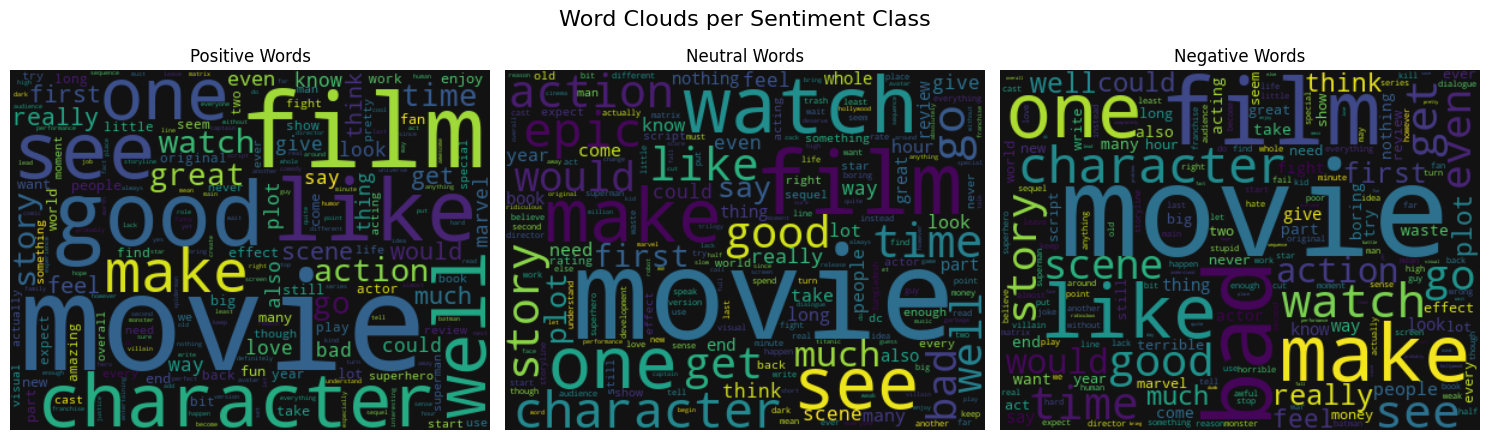

In [278]:
from wordcloud import WordCloud

def plot_word_cloud_per_class(df, text_column, title="Word Clouds per Sentiment Class"):
    """
    Plots word clouds for each sentiment class separately using text data.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the text data and labels.
    text_column (str): The name of the column containing the text data.
    title (str): Title of the subplot.

    """
    # Initialize figure and axes for subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # List of sentiment classes
    sentiment_classes = ['positive', 'neutral', 'negative']

    # Iterate over each sentiment class
    for idx, sentiment in enumerate(sentiment_classes):
        # Filter text data for the current sentiment class
        text_data = ' '.join(df[df['sentiment'] == sentiment][text_column])
        
        # Tokenize using spaCy (optional)
        tokens = tokenize_text(text_data)
        
        # Create word cloud
        wordcloud = WordCloud(width=400, height=300, background_color='#121212').generate_from_frequencies(Counter(tokens))
        
        # Plot word cloud in current subplot
        axs[idx].imshow(wordcloud, interpolation='bilinear')
        axs[idx].set_title(sentiment.capitalize() + ' Words')
        axs[idx].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.show()

plot_word_cloud_per_class(imdb_df, 'review', title="Word Clouds per Sentiment Class")

### Labeling The Target column text

In [9]:
# Replace without explicit conversion
pd.set_option("future.no_silent_downcasting", True)
imdb_df['sentiment'] = imdb_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0}).astype(int)
# imdb_df['sentiment'] = imdb_df['sentiment'].replace({'positive': 1,'negative': 0})

In [10]:
from imblearn.under_sampling import RandomUnderSampler

def under_sampling(df, target_column):
    
    # Separate the features and target variable
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Define the undersampler
    rus = RandomUnderSampler(sampling_strategy='not minority', random_state=101) # resample all classes but the minority class;

    # Apply the undersampler
    X_res, y_res = rus.fit_resample(X, y)
    
   # Combine the resampled features and target back into a DataFrame
    df_undersampled = pd.DataFrame(X_res, columns=X.columns)
    df_undersampled[target_column] = y_res
    # print(df_undersampled[target_column].value_counts())
    return df_undersampled

# Display new class counts
imdb_df = under_sampling(imdb_df, 'sentiment')
print(imdb_df['sentiment'].value_counts())

sentiment
0    1008
1    1008
2    1008
Name: count, dtype: int64


### Splitting data to train and text

In [11]:
from sklearn.model_selection import train_test_split

review_df= imdb_df['review'] #(feature column)
sentiment_df = imdb_df['sentiment'] # (target column)
train_set, test_set, train_labels, test_labels  = train_test_split(review_df, sentiment_df, test_size=0.2, random_state=101)

train_set.shape, test_set.shape, train_labels.shape, test_labels.shape

((2419,), (605,), (2419,), (605,))

In [12]:
from transformers import BertForSequenceClassification,BertTokenizer, XLNetTokenizer, XLNetForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Define compute_metrics function
def compute_metrics(pred):
    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

### Pre-trained Models
- BERT
- XLNet
- Roberta

#### 1. BERT

In [108]:
# # Build Bert model
def train_evaluate_bert(data):
    # Unpacked data
    train_set, test_set, train_labels, test_labels = data
    # Load the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the data
    train_encodings = tokenizer(train_set.tolist(), truncation=True, padding=True, max_length=512)
    test_encodings = tokenizer(test_set.tolist(), truncation=True, padding=True, max_length=512)

    # Create the IMDbDataset
    train_dataset = IMDbDataset(train_encodings, train_labels)
    test_dataset = IMDbDataset(test_encodings, test_labels)

    # Load the pre-trained BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=4,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    training_history = trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Get the predictions for the test set
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=-1)
    
    # Get the test accuracy from the evaluation results
    test_accuracy = eval_result['eval_accuracy']
    
    return trainer, y_pred, test_accuracy, training_history, tokenizer

bert_model, y_pred_bert, bert_accuracy, bert_history, bert_tokenizer = train_evaluate_bert((train_set, test_set, train_labels, test_labels))
print(f"Evaluation results: {bert_accuracy}")

{'loss': 1.1454, 'grad_norm': 5.22814416885376, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.13157894736842105}
{'loss': 1.135, 'grad_norm': 2.238673448562622, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2631578947368421}
{'loss': 1.1235, 'grad_norm': 2.7801566123962402, 'learning_rate': 3e-06, 'epoch': 0.39473684210526316}
{'loss': 1.1017, 'grad_norm': 1.5465229749679565, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5263157894736842}
{'loss': 1.1014, 'grad_norm': 4.548833847045898, 'learning_rate': 5e-06, 'epoch': 0.6578947368421053}
{'loss': 1.0826, 'grad_norm': 3.037411689758301, 'learning_rate': 6e-06, 'epoch': 0.7894736842105263}
{'loss': 1.0354, 'grad_norm': 4.431760787963867, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.9210526315789473}
{'loss': 0.9728, 'grad_norm': 3.287179470062256, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.0526315789473684}
{'loss': 0.9628, 'grad_norm': 3.0434818267822266, 'learning_rate': 9e-06, 'epoch': 1.184210526315789

#### 2. XLNet

In [14]:
def train_evaluate_xlnet(data):
    # Unpack the data
    train_set, test_set, train_labels, test_labels = data
    
    # Load the XLNet tokenizer
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

    # Tokenize the data
    train_encodings = tokenizer(train_set.tolist(), truncation=True, padding=True, max_length=512)
    test_encodings = tokenizer(test_set.tolist(), truncation=True, padding=True, max_length=512)

    # Create the IMDbDataset
    train_dataset = IMDbDataset(train_encodings, train_labels)
    test_dataset = IMDbDataset(test_encodings, test_labels)

    # Load the pre-trained XLNet model
    model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)

    # Define training arguments
    training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    )
    
    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    training_history = trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Get the predictions for the test set
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=-1)

    # Get the test accuracy from the evaluation results
    test_accuracy = eval_result['eval_accuracy']

    return trainer, y_pred, test_accuracy, training_history, tokenizer

# Call the function and get the trained model and other information
xlnet_model, y_pred_xlnet, xlnet_accuracy, xlnet_history, xlnet_tokenizer = train_evaluate_xlnet(data=(train_set, test_set, train_labels, test_labels))
print(f"Evaluation results: {xlnet_accuracy}")

{'loss': 1.1352, 'grad_norm': 15.812265396118164, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.13157894736842105}
{'loss': 1.0885, 'grad_norm': 17.920217514038086, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2631578947368421}
{'loss': 1.0692, 'grad_norm': 14.735326766967773, 'learning_rate': 3e-06, 'epoch': 0.39473684210526316}
{'loss': 1.0679, 'grad_norm': 16.050281524658203, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5263157894736842}
{'loss': 0.9911, 'grad_norm': 18.047576904296875, 'learning_rate': 5e-06, 'epoch': 0.6578947368421053}
{'loss': 0.9517, 'grad_norm': 16.366840362548828, 'learning_rate': 6e-06, 'epoch': 0.7894736842105263}
{'loss': 0.9138, 'grad_norm': 13.949379920959473, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.9210526315789473}
{'loss': 0.8519, 'grad_norm': 11.466557502746582, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.0526315789473684}
{'loss': 0.8664, 'grad_norm': 14.788045883178711, 'learning_rate': 9e-06, 'epoch': 1.1842105

#### Roberta

In [15]:
def train_evaluate_roberta(data):
    # Unpack the data
    train_set, test_set, train_labels, test_labels = data

    # Load RoBERTa tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    # Tokenize the dataset
    train_encodings = tokenizer(train_set.tolist(), truncation=True, padding=True, max_length=512)
    test_encodings = tokenizer(test_set.tolist(), truncation=True, padding=True, max_length=512)

    # Create IMDbDataset instances
    train_dataset = IMDbDataset(train_encodings, train_labels)
    test_dataset = IMDbDataset(test_encodings, test_labels)

    # Load RoBERTa model for sequence classification
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    training_history = trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Get the predictions for the test set
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=-1)

    # Get the test accuracy from the evaluation results
    test_accuracy = eval_result['eval_accuracy']

    return trainer, y_pred, test_accuracy, training_history, tokenizer

# Call the function and get the trained model and other information
roberta_model, y_pred_roberta, roberta_accuracy, roberta_history, roberta_tokenizer = train_evaluate_roberta(data=(train_set, test_set, train_labels, test_labels))
print(f"Evaluation results: {roberta_accuracy}")

{'loss': 1.1027, 'grad_norm': 1.193141222000122, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.13157894736842105}
{'loss': 1.1003, 'grad_norm': 2.128758192062378, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2631578947368421}
{'loss': 1.0982, 'grad_norm': 1.50099778175354, 'learning_rate': 3e-06, 'epoch': 0.39473684210526316}
{'loss': 1.0835, 'grad_norm': 1.1723828315734863, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5263157894736842}
{'loss': 1.0484, 'grad_norm': 4.478116035461426, 'learning_rate': 5e-06, 'epoch': 0.6578947368421053}
{'loss': 1.013, 'grad_norm': 5.835414886474609, 'learning_rate': 6e-06, 'epoch': 0.7894736842105263}
{'loss': 0.9789, 'grad_norm': 4.895008563995361, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.9210526315789473}
{'eval_loss': 0.9683917760848999, 'eval_accuracy': 0.6115702479338843, 'eval_precision': 0.6114181412839705, 'eval_recall': 0.6091600908067265, 'eval_f1': 0.5923923676069598, 'eval_runtime': 109.4128, 'eval_samples_per_

### Machine Learning 
- SVM
- LR
- RF

In [16]:
# Libraries for machine learning data vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
def feature_extraction(X_train, X_test):
    vectorizer= TfidfVectorizer()
    X_train_vectors = vectorizer.fit_transform(X_train)
    X_test_vectors = vectorizer.transform(X_test)
    return X_train_vectors, X_test_vectors

#### 1. SVM

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

# Vectorize the text data
from sklearn.svm import SVC

# Define SVM model
def train_evaluate_svm(data, params=None):
    # Setting default parameters
    if params is None:
        params = {
            'kernel': 'linear',
            'C': 1,
            'random_state': 101
        }
    # Unpack the data
    X_train, X_test, y_train, y_test = data
    
    # Vectorize the text data
    train_vectors, test_vectors = feature_extraction(X_train, X_test)
    
    # Initialize the classifier
    svm_classifier = SVC(**params)
    
    # Train the classifier
    svm_classifier.fit(train_vectors, y_train)
    
    # Make predictions
    y_pred_svm=svm_classifier.predict(test_vectors)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_pred_svm, y_test)
    
    # Precision, Recall, F1
    print(classification_report(y_test, y_pred_svm))
    
    return svm_classifier, y_pred_svm, accuracy

svm_model, y_pred_svm, svm_accuracy = train_evaluate_svm(data=(train_set, test_set, train_labels, test_labels))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       199
           1       0.79      0.77      0.78       215
           2       0.82      0.74      0.78       191

    accuracy                           0.77       605
   macro avg       0.77      0.76      0.77       605
weighted avg       0.77      0.77      0.77       605



#### 2. LR

In [18]:
from sklearn.linear_model import LogisticRegression

# Define Naive Bayes model
def train_evaluate_logistic_regression(data, params=None):
    # Setting default parameters
    if params is None:
        params = {
            'penalty': 'l2',
            'C': 0.8,
            'solver': 'lbfgs',
            'random_state': 101
        }
        
    # Unpack the data
    X_train, X_test, y_train, y_test = data
    
    # Vectorize the text data
    train_vectors, test_vectors = feature_extraction(X_train, X_test)
    
    # Initialize the classifier
    lr = LogisticRegression(**params)
    
    # Train the classifier
    lr.fit(train_vectors, y_train)
    
    # Make predictions
    y_test_pred=lr.predict(test_vectors)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test_pred, y_test)
    
    # Display the classification report
    print(classification_report(y_test, y_test_pred))
    
    return lr, y_test_pred, accuracy

lr_model, y_pred_lr, lr_accuracy = train_evaluate_logistic_regression(data=(train_set, test_set, train_labels, test_labels))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       199
           1       0.77      0.81      0.79       215
           2       0.80      0.77      0.79       191

    accuracy                           0.77       605
   macro avg       0.77      0.77      0.77       605
weighted avg       0.77      0.77      0.77       605



#### 3. RF

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest model
def train_evaluate_random_forest(data, params=None):
    # Setting default parameters
    if params is None:
        params = {
            'n_estimators': 2000,
            'max_depth': None,
            'min_samples_split': 4,
            'min_samples_leaf': 1,
            'bootstrap': False,
            'random_state': 101
        }
        
    # Unpack the data
    X_train, X_test, y_train, y_test = data
    
    # Vectorize the text data
    train_vectors, test_vectors = feature_extraction(X_train, X_test)
    
    # Initialize the classifier
    rf = RandomForestClassifier(**params)
    
    # Train the classifier
    rf.fit(train_vectors, y_train)
    
    # Make predictions
    y_test_pred=rf.predict(test_vectors)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test_pred, y_test)
    
    # Display the classification report
    print(classification_report(y_test, y_test_pred))
    
    return rf, y_test_pred, accuracy

rf_model, y_pred_rf, rf_accuracy = train_evaluate_random_forest(data=(train_set, test_set, train_labels, test_labels))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       199
           1       0.86      0.80      0.83       215
           2       0.72      0.83      0.77       191

    accuracy                           0.77       605
   macro avg       0.77      0.77      0.77       605
weighted avg       0.78      0.77      0.77       605



In [20]:
# ParameterGrid
from sklearn.model_selection import ParameterGrid

def hyperparameter_tuning_classification(classifier, param, data, verbose = 1):
    """
    Perform hyperparameter tuning for a given classifier and returns the best model as well as its hyperparameters.
    
    Parameters:
    - classifier (str): Classifier type ('rf', 'svm', 'lr').
    - param (dict): Hyperparameter grid for the classifier.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.
    - verbose (int, optional): Controls the verbosity of the tuning process.
    
    Returns:
    - best_model: Best-tuned model based on testing accuracy.
    - best_params: Best hyperparameters found during tuning.
    """
    # Unpack the data
    X_train, X_test, y_train, y_test = data
    
    # Vectorize the text data
    train_vectors, test_vectors = feature_extraction(X_train, X_test)
    
    model_constructors = {
        'svm': SVC,
        'rf': RandomForestClassifier,
        'lr': LogisticRegression,
    }

    if classifier not in model_constructors:
        raise Exception('Incorrent classifier. Please make sure it is within the options')
    
    best_model = None
    best_params = None
    best_y_pred = None
    best_acc = 0

    # Create all possible combinations of hyperparameters
    param_combinations = ParameterGrid(param)

    # Iterate over all combinations of hyperparameters
    for params in param_combinations:
        # Create a new classifier with the current set of hyperparameters
        clf = model_constructors[classifier]()
        clf.set_params(**params)

        # Fit the classifier
        clf.fit(train_vectors, y_train)
        
        # Evaluate the classifier
        pred_test = clf.predict(test_vectors)
        acc = accuracy_score(y_test, pred_test)

        # Print the hyperparameters and testing accuracy if verbose more than 0
        if verbose > 0:
            print("Hyperparameters:", params)
            print(f"Testing Accuracy: {acc}\n")
        
        # Update the best hyperparameters and model as well as the best accuracy
        if acc > best_acc:
            best_model = clf
            best_params = params
            best_acc = acc
            best_y_pred = pred_test

    # Print the best hyperparameters and testing accuracy
    print("Best Hyperparameters:", best_params)
    print("Best Testing Accuracy:", best_acc)

    return best_model, best_params, best_y_pred, best_acc

In [21]:
# Define the parameter grid for SVM
params_grid_svm = {
    'C': [0.6, 0.8, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    # 'decision_function_shape': ['ovo', 'ovr'],
    'random_state': [42, 101]
}

#hyperparameter tuning svm
svm_model, svm_params, svm_y_pred, svm_accuracy = hyperparameter_tuning_classification('svm', params_grid_svm, data=(train_set, test_set, train_labels, test_labels), verbose = 0)

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}
Best Testing Accuracy: 0.7702479338842976


In [22]:
#Define the parameter grid for LR
params_grid_lr = {
    'penalty': ['l2'],
    'C': [0.6, 0.8, 1],
    'solver': [ 'newton-cg', 'lbfgs', 'sag',],
    'random_state': [101]
}
lr_model, lr_params, lr_y_pred, lr_acc = hyperparameter_tuning_classification('lr', params_grid_lr, data=(train_set, test_set, train_labels, test_labels), verbose = 0)

Best Hyperparameters: {'C': 0.6, 'penalty': 'l2', 'random_state': 101, 'solver': 'newton-cg'}
Best Testing Accuracy: 0.7735537190082644


In [23]:
# Define the parameter grid for RF
params_grid_rf = {
    'n_estimators': [2000, 3000],
    'max_depth': [None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1],
    'bootstrap': [False],
    'random_state': [101],
}
#hyperparameter tuning rf
rf_model, rf_params, rf_y_pred, rf_acc = hyperparameter_tuning_classification('rf', params_grid_rf, data=(train_set, test_set, train_labels, test_labels), verbose = 0)

Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2000, 'random_state': 101}
Best Testing Accuracy: 0.771900826446281


### Deep Learning
- LSTM
- CNN
- CNN-LSTM

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout,  Conv1D, MaxPooling1D, LSTM, Flatten
# from tf.keras.callbacks import ModelCheckpoint, EarlyStopping

def preprocess_data_for_deep_learning(data):
    # Unpack the data
    train_set, test_set, train_labels, test_labels = data
    
    # Ensure all texts are strings in case there are any non-string types like float
    train_set = [str(text) for text in train_set]
    test_set = [str(text) for text in test_set]

    # Define the maximum number of words and sequence length
    vocab_size = max(len(set(text.split())) for text in train_set + test_set)
    # Analyze sequence lengths and adjust max_length if necessary
    all_texts = train_set + test_set
    sequence_lengths = [len(text.split()) for text in all_texts]
    max_length = min(max(sequence_lengths), 500)
    
    oov_tok = '<OOV>'
    # Initialize the tokenizer
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_set)

    # Convert texts to sequences
    train_sequences = tokenizer.texts_to_sequences(train_set)
    test_sequences = tokenizer.texts_to_sequences(test_set)

    # Pad sequences
    # padding='post', truncating='post'
    X_train = pad_sequences(train_sequences, maxlen=max_length)
    X_test = pad_sequences(test_sequences, maxlen=max_length)
    
    return X_train, X_test, train_labels, test_labels, vocab_size, max_length

X_train_dl, X_test_dl, y_train_dl, y_test_dl, vocab_size, max_length = preprocess_data_for_deep_learning(data=(train_set, test_set, train_labels, test_labels))

#### 1. LSTM

In [109]:
# Define the model
def train_evaluate_lstm(data, model=None, fit_params={'epochs':10, 'batch_size':32}):
    # Unpack the data
    X_train, X_test, y_train, y_test, vocab_size, max_length = data
    
    # Get the number of unique classes
    num_classes = len(np.unique(y_train))
    
    # Determine the appropriate loss function and number of units in the last layer
    if num_classes == 2:
        loss = 'binary_crossentropy'
        output_units = 1
        last_activation = 'sigmoid'
    else:
        loss = 'sparse_categorical_crossentropy'
        output_units = num_classes
        last_activation = 'softmax'
    
    if model is None:
        model = Sequential([
            Input(shape=(max_length,)),
            Embedding(input_dim=vocab_size, output_dim=128),
            # SpatialDropout1D(0.2),
            LSTM(256, dropout=0.4, recurrent_dropout=0.2, return_sequences=True),
            Dense(128, activation='relu'),
            # SpatialDropout1D(0.2),
            LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True),
            Dense(128, activation='relu'),
            # SpatialDropout1D(0.2),
            LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        ])
            # Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
            # Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
            # Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    
    # add last layer
    model.add(Dense(units=output_units, activation=last_activation))
    
    # Compile the model
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=fit_params['epochs'], batch_size=fit_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    
    #Make predictions on the test set
    y_pred_lstm = model.predict(X_test)
    
    # Convert the predictions to class labels
    if loss != 'binary_crossentropy':
        y_pred= np.argmax(y_pred_lstm, axis=1)
    else:
        y_pred = (y_pred_lstm > 0.5).astype(int)
    
    print(f'Test Accuracy: {accuracy}')
    
    return model, y_pred, accuracy, history
# Define the model
fit_params={'epochs':20, 'batch_size':64}
lstm_model, y_pred_lstm, lstm_accuracy,lstm_history = train_evaluate_lstm(data=(X_train_dl, X_test_dl, y_train_dl, y_test_dl, vocab_size, max_length), model=None, fit_params=fit_params)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4896 - loss: 0.9897 - val_accuracy: 0.5785 - val_loss: 0.8559
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5600 - loss: 0.8870 - val_accuracy: 0.5901 - val_loss: 0.8283
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5940 - loss: 0.8269 - val_accuracy: 0.6645 - val_loss: 0.7668
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7051 - loss: 0.6984 - val_accuracy: 0.6744 - val_loss: 0.7183
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7695 - loss: 0.6096 - val_accuracy: 0.6926 - val_loss: 0.7466
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7544 - loss: 0.6236 - val_accuracy: 0.7289 - val_loss: 0.6644
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8200 - loss: 0.5252 - val_accuracy: 0.7537 - val_loss: 0.6442
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8372 - loss: 0.4806 - val_accuracy: 0.7240 - val_loss:

#### 2. CNN

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Define CNN model
def train_evaluate_cnn(data, model=None, fit_params={'epochs':10, 'batch_size':32}):
    # Unpack the data
    X_train, X_test, y_train, y_test, vocab_size, max_length = data
    
    # Get the number of unique classes
    num_classes = len(np.unique(y_train))
    
    output_dim= len(np.unique(y_train))
    
    # Determine the appropriate loss function and number of units in the last layer
    if num_classes == 2:
        loss = 'binary_crossentropy'
        output_units = 1
        last_activation = 'sigmoid'
    else:
        loss = 'sparse_categorical_crossentropy'
        output_units = num_classes
        last_activation = 'softmax'
    
    if model is None:
        model = Sequential([
            Input(shape=(max_length,)),
            Embedding(input_dim=vocab_size, output_dim=128),
            Dropout(0.6),
            Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
            Dense(128, activation='relu'),
            Dropout(0.2),
            MaxPooling1D(pool_size=4),
            Dense(256, activation='relu'),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(output_units, activation=last_activation)
        ])
    
    # Compile the model
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=fit_params['epochs'], batch_size=fit_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    
    #Make predictions on the test set
    y_pred_cnn = model.predict(X_test)
    
    # Convert the predictions to class labels
    if loss != 'binary_crossentropy':
        y_pred= np.argmax(y_pred_cnn, axis=1)
    else:
        y_pred = (y_pred_cnn > 0.5).astype(int)
    
    print(f'Test Accuracy: {accuracy}')
    
    return model, y_pred, accuracy, history

fit_params={'epochs':20, 'batch_size':64}
cnn_model, y_pred_cnn, cnn_accuracy, cnn_history = train_evaluate_cnn(data=(X_train_dl, X_test_dl, y_train_dl, y_test_dl, vocab_size, max_length), model=None, fit_params=fit_params)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.3878 - loss: 1.0891 - val_accuracy: 0.5488 - val_loss: 0.9857
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5596 - loss: 0.9216 - val_accuracy: 0.5603 - val_loss: 0.9248
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5706 - loss: 0.8557 - val_accuracy: 0.5372 - val_loss: 0.8952
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6594 - loss: 0.7684 - val_accuracy: 0.7107 - val_loss: 0.7592
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7422 - loss: 0.6339 - val_accuracy: 0.7322 - val_loss: 0.6962
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7972 - loss: 0.5331 - val_accuracy: 0.7157 - val_loss: 0.6917
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8365 - loss: 0.4619 - val_accuracy: 0.7355 - val_loss: 0.6863
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8461 - loss: 0.4128 - val_accuracy: 0.7438 - v

#### 3. CNN-LSTM

In [79]:
# import tensorflow.keras
# from tensorflow.keras.models import Sequential

# Define the model
def train_evaluate_cnn_lstm(data, model=None, fit_params={'epochs':10, 'batch_size':32}):
    # Unpack the data
    X_train, X_test, y_train, y_test, vocab_size, max_length = data
    
    # Get the number of unique classes
    num_classes = len(np.unique(y_train))
    
    # Determine the appropriate loss function and number of units in the last layer
    if num_classes == 2:
        loss = 'binary_crossentropy'
        output_units = 1
        last_activation = 'sigmoid'
    else:
        loss = 'sparse_categorical_crossentropy'
        output_units = num_classes
        last_activation = 'softmax'
    
    if model is None:
        model = Sequential([
            Input(shape=(max_length,)),
            Embedding(input_dim=vocab_size, output_dim=128),
            Dropout(0.6),
            Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
            Dense(128, activation='relu'),
            MaxPooling1D(pool_size=4),
            Dropout(0.2),
            LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
            Dense(128, activation='relu'),
            Dropout(0.2),
            LSTM(128, dropout=0.2, recurrent_dropout=0.2)
        ])
    
    # add last layer
    model.add(Dense(units=output_units, activation=last_activation))
    
    # Compile the model
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=fit_params['epochs'], batch_size=fit_params['batch_size'], validation_data=(X_test, y_test), verbose=1)
    
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    
    #Make predictions on the test set
    y_pred_cnn_lstm = model.predict(X_test)
    
    # Convert the predictions to class labels
    if loss != 'binary_crossentropy':
        y_pred = np.argmax(y_pred_cnn_lstm, axis=1)
    else:
        y_pred = (y_pred_cnn_lstm > 0.5).astype(int)
    
    print(f'Test Accuracy: {accuracy}')
    
    return model, y_pred, accuracy, history

# Usage example
fit_params = {'epochs': 10, 'batch_size': 64}
cnn_lstm_model, y_pred_cnn_lstm, cnn_lstm_accuracy, cnn_lstm_history = train_evaluate_cnn_lstm(data=(X_train_dl, X_test_dl, y_train_dl, y_test_dl, vocab_size, max_length), model=None, fit_params=fit_params)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 268ms/step - accuracy: 0.4646 - loss: 1.0233 - val_accuracy: 0.5884 - val_loss: 0.8705
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.5592 - loss: 0.8812 - val_accuracy: 0.5917 - val_loss: 0.8243
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.6106 - loss: 0.8209 - val_accuracy: 0.6612 - val_loss: 0.7702
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.6984 - loss: 0.7172 - val_accuracy: 0.6893 - val_loss: 0.7352
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.7324 - loss: 0.6686 - val_accuracy: 0.7107 - val_loss: 0.6958
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7358 - loss: 0.6350 - val_accuracy: 0.7091 - val_loss: 0.6953
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.7445 - loss: 0.6223 - val_accuracy: 0.6942 - val_loss: 0.6985
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.7604 - loss: 0.5891 - val_accuracy: 

In [150]:
# Create a dictionary to store prediction results
predictions = {
    1: {
        'IMDB Movie Review': [],
    }
}

# 0. Model Name, 1. Model, 2. Prediction, 3. Actual, 4. Accuracy, 5. Parameters, 6. History, 7. Tokenizer
# Append prediction results for each model
predictions[1]['IMDB Movie Review'].append(('SVM', svm_model, y_pred_svm, test_labels, svm_accuracy, svm_model.get_params(), None, None))
predictions[1]['IMDB Movie Review'].append(('LR', lr_model, y_pred_lr, test_labels, lr_accuracy, lr_model.get_params(), None, None))
predictions[1]['IMDB Movie Review'].append(('RF', rf_model, y_pred_rf, test_labels, rf_accuracy, rf_model.get_params(), None, None))
predictions[1]['IMDB Movie Review'].append(('CNN', cnn_model, y_pred_cnn, y_test_dl, cnn_accuracy, cnn_model.get_config(), cnn_history, None))
predictions[1]['IMDB Movie Review'].append(('LSTM', lstm_model, y_pred_lstm, y_test_dl, lstm_accuracy, lstm_model.get_config(), lstm_history, None))
predictions[1]['IMDB Movie Review'].append(('CNN-LSTM', cnn_lstm_model, y_pred_cnn_lstm, y_test_dl, cnn_lstm_accuracy, cnn_lstm_model.get_config(), cnn_lstm_history, None))
predictions[1]['IMDB Movie Review'].append(('BERT', bert_model, y_pred_bert, y_test_dl, bert_accuracy, None, bert_history, bert_tokenizer))
predictions[1]['IMDB Movie Review'].append(('RoBERTa', roberta_model, y_pred_roberta, y_test_dl, roberta_accuracy, None, roberta_history, roberta_tokenizer))
predictions[1]['IMDB Movie Review'].append(('XLNET', xlnet_model, y_pred_xlnet, y_test_dl, xlnet_accuracy, None, xlnet_history, xlnet_tokenizer))

## Error Analysis

In [151]:
# import roc curve
# Plot model history
import matplotlib.pyplot as plt

def plot_history(history, title = 'Model Loss'):
    """
    Plots the training and validation loss from a Keras model's history.
    
    Parameters:
        history: A Keras History object returned from the fit method.
        
    Returns:
        None
    """
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
# Display formatted metrics
def display_metrics(metrics):
    # Find the maximum length of 'Best Parameter' across all models
    max_param_length = max(len(str(details['Best Parameter'])) for details in metrics.values())
    
    # Define the minimum width for the 'Best Parameter' column
    min_param_width = 20
    # Ensure the column is at least the minimum width
    best_param_width = max(max_param_length, min_param_width)
    
    # Print the header
    print(f"{'Model':<15} {'Best Parameter':<{best_param_width}} {'Accuracy'}")
    print('-' * (15 + best_param_width + 10))
    
    # Print each row
    for model, details in metrics.items():
        best_param = str(details['Best Parameter'])
        accuracy = details['Accuracy']
        print(f"{model:<15} {best_param:<{best_param_width}} {accuracy:.3f}")

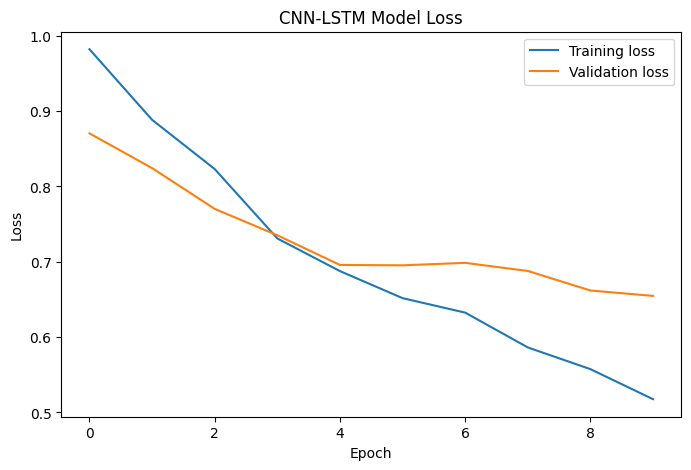

In [152]:
plot_history(cnn_lstm_history, title='CNN-LSTM Model Loss')

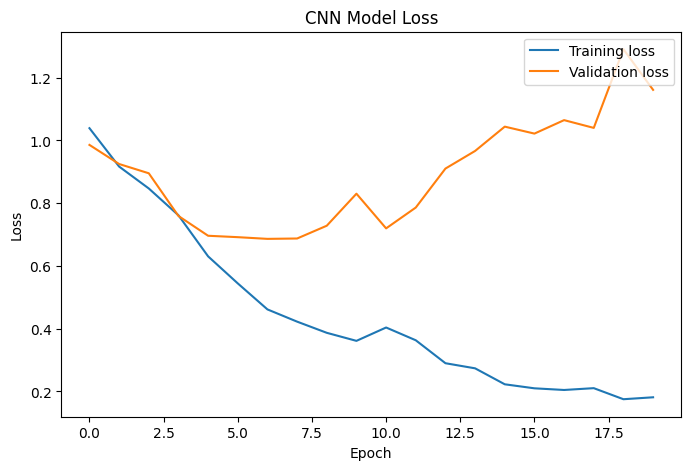

In [153]:
plot_history(cnn_history, title='CNN Model Loss')

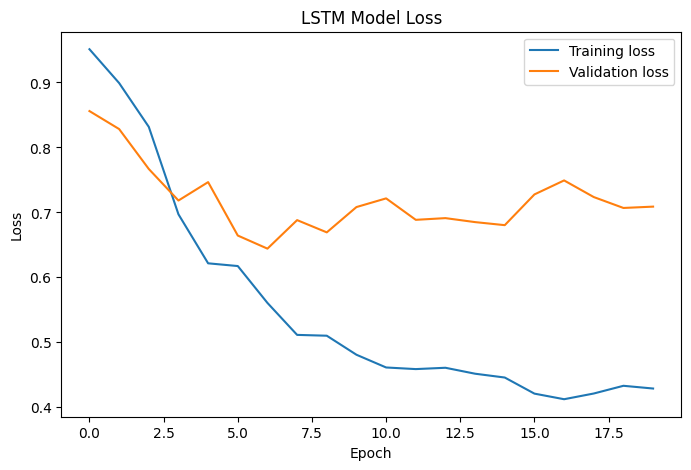

In [154]:
plot_history(lstm_history, title='LSTM Model Loss')

In [155]:
metrics = {
    'SVM': {'Best Parameter': svm_model.get_params(), 'Accuracy': svm_accuracy},
    'LR ': {'Best Parameter': lr_model.get_params(), 'Accuracy': lr_accuracy},
    'Random Forest': {'Best Parameter': rf_model.get_params(), 'Accuracy': rf_accuracy},
    'LSTM': {'Best Parameter': lstm_model.get_config(), 'Accuracy': lstm_accuracy},
    'CNN': {'Best Parameter': cnn_model.get_config(), 'Accuracy': cnn_accuracy},
    'CNN-LSTM': {'Best Parameter': cnn_lstm_model.get_config(), 'Accuracy': cnn_lstm_accuracy},
}
        
# Usage example
display_metrics(metrics)

Model           Best Parameter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# Performance Evaluation

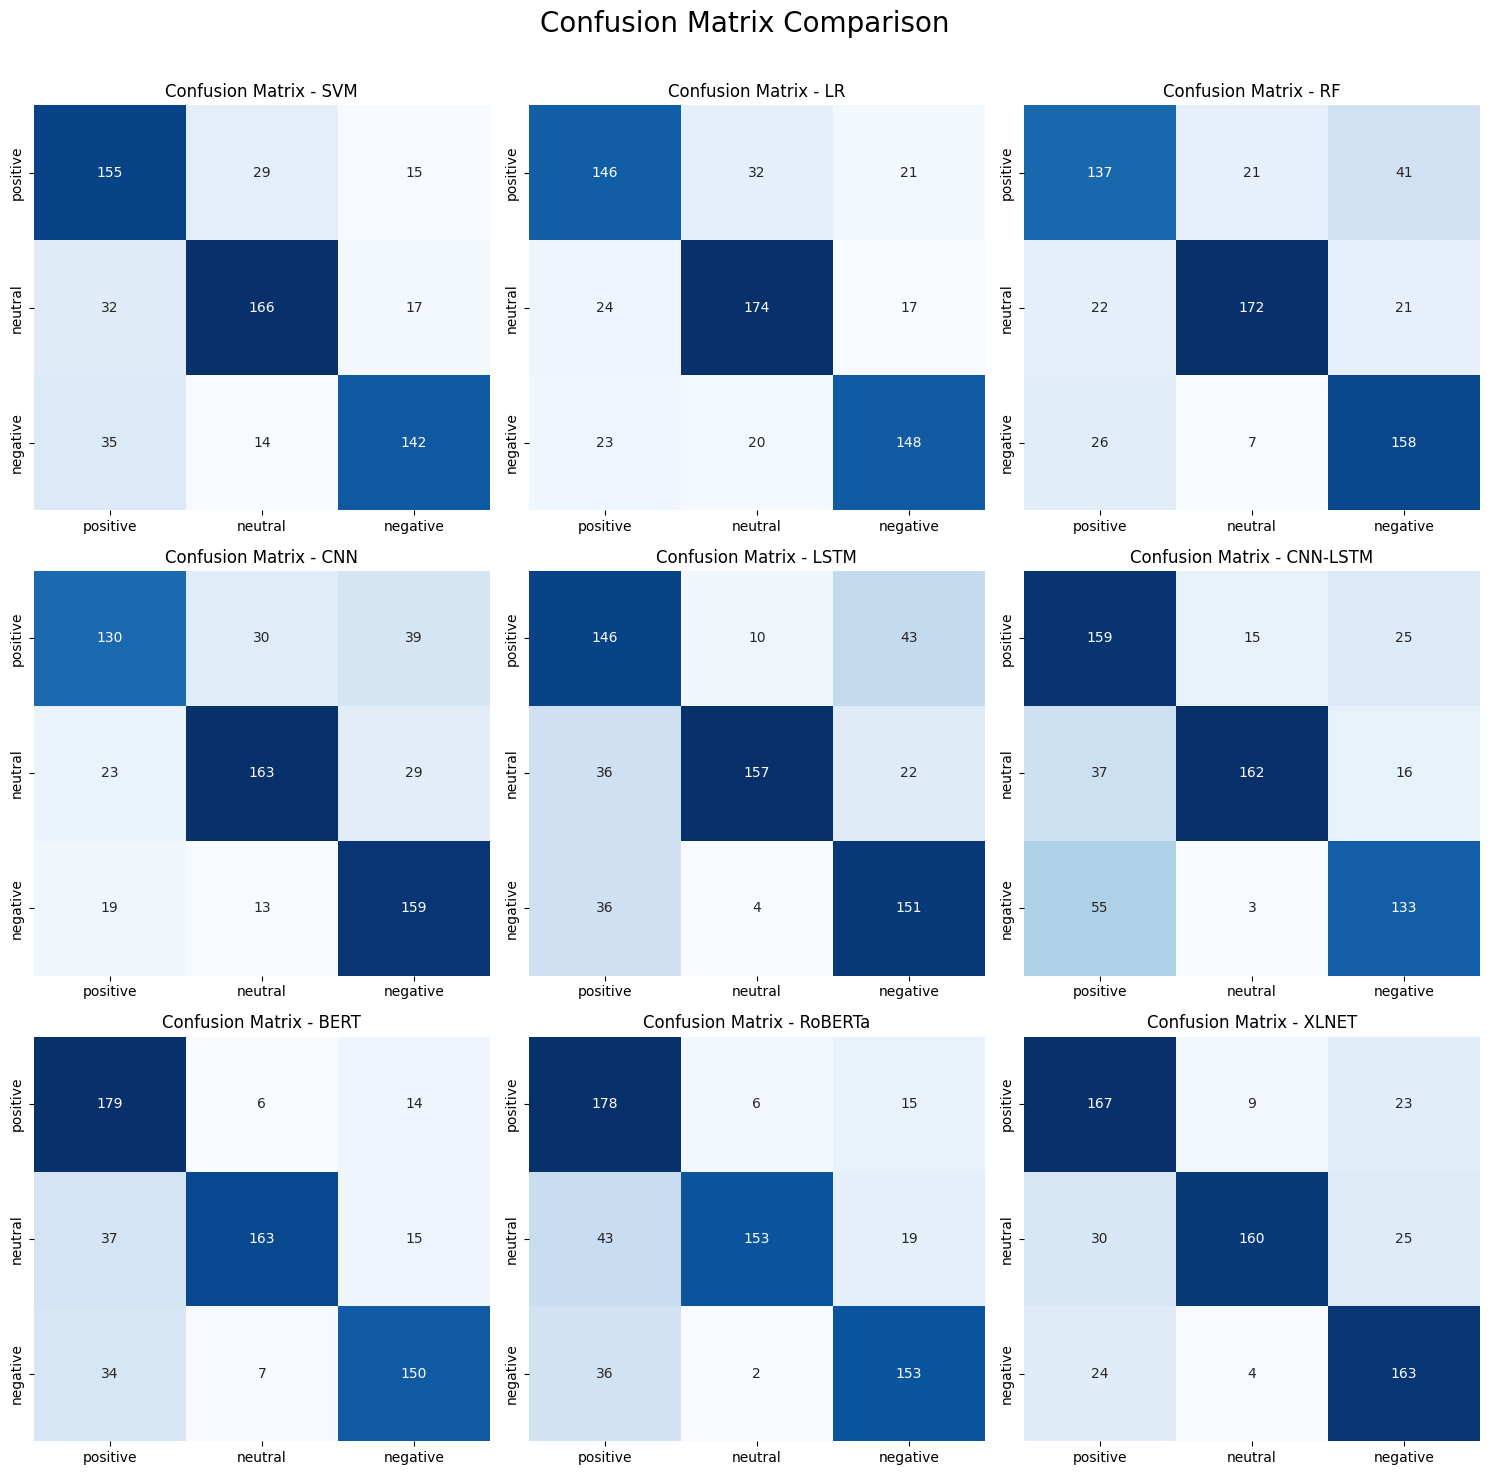

In [156]:
import seaborn as sns

# Define function to plot confusion matrix
def confusion_matrix_comparison(predictions, prediction_id, prediction_name, title='Confusion Matrix Comparison', figsize=(15, 15)):
    """
    Plots confusion matrices for multiple models in a grid for a specific task.

    Parameters:
    - predictions: Dictionary containing model predictions and actual labels.
    - prediction_id: ID of the task (e.g., 1).
    - prediction_name: Name of the task (e.g., 'IMDB Movie Review').
    - title: Title for the entire figure.
    - figsize: Size of the entire figure.
    """
    # Define class labels
    labels = ['positive', 'neutral', 'negative']

    # Extract the predictions for the specified task
    model_prediction = predictions[prediction_id][prediction_name]
    
    # Calculate number of models
    num_models = len(model_prediction)
    # print(f'Number of models: {num_models}')
    # Determine grid size based on the number of models
    grid_size = (num_models // 3, 3)
    
    # Create a grid for the confusion matrices
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Plot each confusion matrix
    for i, (model_name, _, y_pred, y_true, *_rest) in enumerate(model_prediction):
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=axes[i], cbar=False, cmap='Blues')
        
        # Set title and labels
        axes[i].set_title(f'Confusion Matrix - {model_name}')
        
    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and set main title
    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Show plot
    plt.show()

# Call the function
confusion_matrix_comparison(predictions, 1, 'IMDB Movie Review')


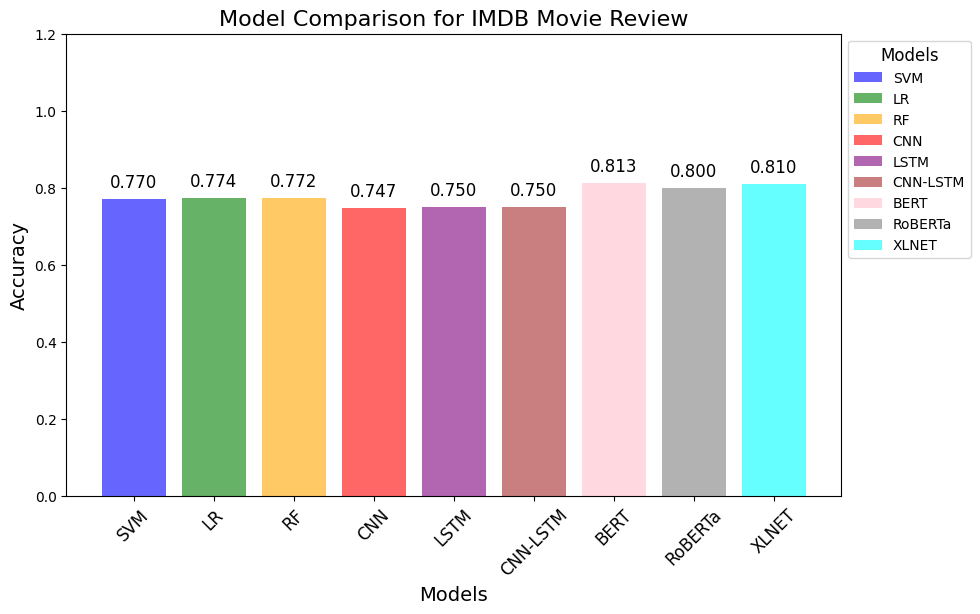

In [157]:
def accuracy_comparison(predictions, num, condition):
    models = [entry[0] for entry in predictions[num][condition]]
    accuracies = [entry[4] for entry in predictions[num][condition]]

    # Define different colors for each bar
    colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(models, accuracies, color=colors, alpha=0.6)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Models', fontsize=14)
    ax.set_title(f'Model Comparison for {condition}', fontsize=16)
    plt.ylim([0, 1.2])
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)

    # Display the accuracy values on top of the bars
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=12)

    # Display model names outside the bars
    for bar, model in zip(bars, models):
        height = bar.get_height()

    # Add a legend for the colors
    ax.legend(bars, models, title='Models', title_fontsize='12', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()
    
accuracy_comparison(predictions, 1, 'IMDB Movie Review')

### Testing for models

In [158]:
import joblib
from transformers import PreTrainedModel

def save_model(model, model_name, tokenizer=None):
    model_dir = f'model/{model_name.lower()}'
    # Save the model
    if tokenizer is not None and model_name.lower() in ['bert', 'xlnet', 'roberta']:
        model = model.model
        
    if isinstance(model, PreTrainedModel):
        # print(f"Saving model to {model_dir}")
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)
        
    elif hasattr(model, 'save'):
        filename = f'{model_dir}.keras'
        model.save(filename)
    else:
        filename = f'{model_dir}.sav'
        joblib.dump(model, filename)
    print(f"Model saved as {model_dir}")

for model_tuple in predictions[1]['IMDB Movie Review']:
    save_model(model_tuple[1], model_tuple[0], model_tuple[7])

Model saved as model/svm
Model saved as model/lr
Model saved as model/rf
Model saved as model/cnn
Model saved as model/lstm
Model saved as model/cnn-lstm
Model saved as model/bert
Model saved as model/roberta
Model saved as model/xlnet


In [159]:
import tensorflow as tf
from transformers import AutoModelForSequenceClassification, AutoTokenizer
def load_imdb_dataset():
    # Define the list of CSV file paths
    file_paths = [
        'data/processed/imdb_cleaned_1.csv',
        'data/processed/imdb_cleaned_2.csv',
        'data/processed/imdb_cleaned_3.csv',
        'data/processed/imdb_cleaned_4_5_6.csv',
        'data/processed/imdb_cleaned_7.csv',
        'data/processed/imdb_cleaned_8.csv',
        'data/processed/imdb_cleaned_9.csv',
    ]
    # Load all CSV files into a single DataFrame
    dataframes = [pd.read_csv(file, usecols=['review', 'sentiment']) for file in file_paths]

    # Concatenate all dataframes
    imdb_df = pd.concat(dataframes, ignore_index=True)

    # Drop any rows with missing values
    imdb_df.dropna(inplace=True)
    
    # Class balance
    imdb_df = under_sampling(imdb_df, 'sentiment')
    
    #Split into train and test
    train_set, test_set = train_test_split(imdb_df, test_size=0.2, random_state=42)
    
    review_df= imdb_df['review']
    sentiment_df = imdb_df['sentiment']
    train_set, test_set, train_labels, test_labels  = train_test_split(review_df, sentiment_df, test_size=0.2, random_state=101)
    
    return train_set, test_set, train_labels, test_labels

    
def pred_user_sentence(pred_sentences, model, tokenizer=None):
    '''
    Parameters
    ----------
    pred_sentences : str
        The sentence to be predicted
    model : The model to be used for prediction (svm_model, lr_model, rf_model, cnn-model, lstm_model, cnn_lstm_model)
    '''
    
    if model is None:
        return
    
    train_set,_,_,_ = load_imdb_dataset()
    
    labels = ['Negative', 'Neutral', 'Positive']
    processed_sentences = preprocess_text(pred_sentences)
    extracted_keywords = tokenize_text(processed_sentences)
    
    if isinstance(model, PreTrainedModel):
        # Automatically detect and load the appropriate tokenizer for the model
        tokenizer = tokenizer
        
        # Tokenize the sentence for the model
        encoded_input = tokenizer(processed_sentences, max_length=512, padding=True, truncation=True, return_tensors='pt')
        
        with torch.no_grad():
            outputs = model(**encoded_input)
            predictions = outputs.logits
        
        # Convert logits to probabilities and then get the predicted label
        predicted_class_idx = np.argmax(predictions.detach().numpy(), axis=1)[0]
        label = labels[predicted_class_idx]
        
    elif hasattr(model, 'save'):
        _, processed_sentences_sequences, _, _, _, _ = preprocess_data_for_deep_learning(data=(train_set, [processed_sentences], None, None))
        
        label = model.predict(processed_sentences_sequences)
        label = labels[np.argmax(label)]
    else:
        _, transformed_sentence = feature_extraction(train_set, [processed_sentences])
        label_idx = model.predict(transformed_sentence)[0]
        label = labels[label_idx]
    return label, extracted_keywords

In [160]:
def load_pretrained_model_and_tokenizer(model_name):
    model_dir = f'model/{model_name.lower()}'
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    return model, tokenizer

def load_and_predict(pred_sentence, model_name):
    '''
    Parameters:
    pred_sentence: str
    model_name: str
    '''
    tokenizer = None
    
    if model_name not in ['bert', 'xlnet', 'roberta', 'lr', 'svm', 'rf', 'cnn', 'lstm', 'cnn_lstm']:
        raise ValueError("Invalid model name. Please choose from 'bert', 'xlnet', 'roberta', 'lr', 'svm', 'rf', 'cnn', 'lstm', 'cnn_lstm'.")
    
    print(f"Loading model: {model_name}")
    # Check if the model is a pre-trained model from Hugging Face Transformers
    if model_name.lower() in ['bert', 'xlnet', 'roberta']:
        # Load the pre-trained model and tokenizer from the model directory
        # model_dir = f'model/{model_name.lower()}'
        model, tokenizer = load_pretrained_model_and_tokenizer(model_name)
        
    elif model_name.lower() in ['lr', 'svm', 'rf']:
        # Load a machine learning model saved with joblib
        filename = f'model/{model_name.lower()}.sav'
        model = joblib.load(filename)
    else:
        # Load a deep learning model saved in Keras format
        filename = f'model/{model_name.lower()}.keras'
        model = tf.keras.models.load_model(filename)
    
    # Call the prediction function
    predicted_sentiment, extracted_keywords = pred_user_sentence(pred_sentence, model=model, tokenizer = tokenizer)
    return predicted_sentiment, extracted_keywords
    
# Example of using load_and_predict
pred_sentences = [
    'worst movie of my life, will never watch movies from this series', 
    'Wow, blew my mind, what a movie by Marvel, animation and story is amazing',
    'I have never seen such beautiful acting in movies',
    'It is fine to watch'
]
predicted_sentiment = []
extracted_keywords = []
# Multiple predictions
# for pred_sentence in pred_sentences:
#     sentiment, keywords = load_and_predict(pred_sentence, 'bert')
#     predicted_sentiment.append(sentiment)
#     extracted_keywords.append(keywords)
#     print(sentiment,': ', pred_sentence, ' | Extracted Keywords:', keywords)

# Single prediction
sentiment, keywords = load_and_predict(pred_sentences[0], 'bert')
predicted_sentiment.append(sentiment)
extracted_keywords.append(keywords)
print(sentiment,': ', pred_sentences[0], ' | Extracted Keywords:', keywords)

Loading model: bert
Negative :  worst movie of my life, will never watch movies from this series  | Extracted Keywords: ['bad', 'movie', 'life', 'never', 'watch', 'movie']
